# Original Data Processing

**Abstract:**
Processing datasets for correlation analysis.

**Description:**
In the following cell, two different dimensions of dataset processed:
1. Water Use (**section 1**):
    1. Total Water Use
    2. YR Water Use
    3. YR Water Ratio
2. Institution restricts (**section 2**):
    1. Planning
    2. Quota
    3. Satisfied Ratio

Finally, for the two dimensions, design a function for flexible time period extraction (**section 3**).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys
import os

sys.path.append("..")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'

In [2]:
from config import ROOT, SCHEME_87, PROVINCES_CHN2ENG
os.chdir(ROOT)

## Section 1. Water Use data

**Abstract:**
One-sentence description

**Description:**
In the following cell, I processed following three datasets:
* Total Water Use
* YR Water Use
* YR Water Ratio

---
**Relies**:
1. China's Water Use datasets by [Feng Zhou et al., 2020](http://www.pnas.org/lookup/doi/10.1073/pnas.1909902117).
2. Yellow River's Water Use data from [Water Resources Bulletin](http://www.yrcc.gov.cn/other/hhgb/) by YRCC


---
**Digested purposes:**
1. 
2. 
3. 

In [3]:
from matplotlib.gridspec import GridSpec

data_yr = pd.read_csv(os.path.join(ROOT, "data/source/yr_consumption_1988-2000.csv"), index_col=0)
data_all = pd.read_csv(os.path.join(ROOT, "data/processed/merged_data.csv"), index_col=0)

### Total Water Use
# New dataframe for cleaned Total_WU data storing.
data = pd.DataFrame()
data_all = data_all.groupby(["Province", "Year"])['Total water use'].sum()  # Sum up by province
for province in SCHEME_87.keys():  # Filter used provinces
    data[province] = data_all[province]
data = data.loc[1988:2012, :] * 10  # units are different

### YR Water use    
data_yr = data_yr.loc[1988:2012, :]
data_yr.set_axis([PROVINCES_CHN2ENG[col] for col in data_yr.columns], axis='columns', inplace=True)
data_yr.index.name = 'Year'

### ratio
# ratio = data_yr / data_all
# ratio.head()

data.to_csv(os.path.join(ROOT, "data/processed/wu_all.csv"))  # Yellow River Water Use
data_yr.to_csv(os.path.join(ROOT, "data/processed/wu_yr.csv"))  # Total water use

### Cleaned Dataset Plotting ###
data.tail()
data_yr.tail()

,Qinghai,Gansu,Ningxia,Neimeng,Shanxi,Shaanxi,Henan,Shandong
Year,,,,,,,,
2008,26.297343,113.615777,73.974602,163.674284,58.527345,80.480037,234.708176,221.360257
2009,23.395051,117.251951,71.786055,170.471881,56.079920,77.676997,243.569657,222.445098
2010,29.608340,118.577120,71.939389,172.178787,61.946857,77.146705,230.103017,218.458303
2011,30.229601,114.203911,68.823800,172.025955,66.905358,79.420670,232.840282,218.758648
2012,21.349500,114.563263,66.187172,164.957000,69.549879,80.208212,247.320734,226.024489


,Qinghai,Gansu,Ningxia,Neimeng,Shaanxi,Shanxi,Henan,Shandong
Year,,,,,,,,
2008,11.70,30.00,38.60,57.10,26.80,14.50,39.40,67.60
2009,11.04,29.91,37.98,61.34,25.58,15.08,43.36,73.36
2010,10.51,30.32,35.47,61.29,24.42,18.17,44.10,74.49
2011,10.53,33.23,37.01,61.50,26.60,20.54,51.95,78.87
2012,9.02,31.88,37.55,53.94,27.72,20.66,53.86,81.62


<AxesSubplot:xlabel='Provinces', ylabel='YR Water Use Ratio'>

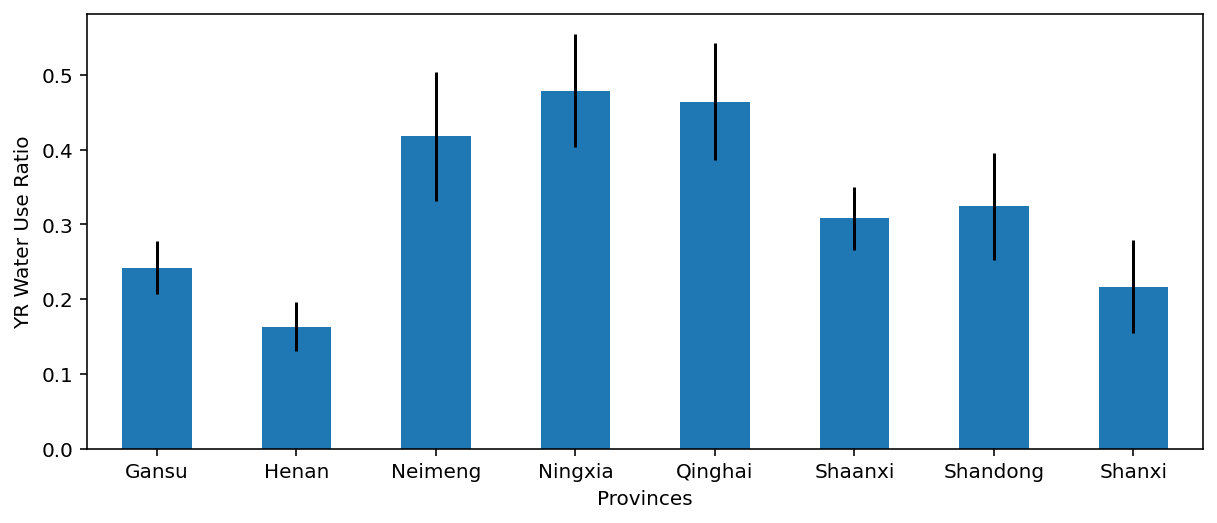

In [4]:
## Ratio
wu_yr = pd.read_csv(os.path.join(ROOT, "data/processed/wu_yr.csv"), index_col=0)
wu_total = pd.read_csv(os.path.join(ROOT, "data/processed/wu_all.csv"), index_col=0)
ratio = wu_yr / wu_total

# save and plot
ratio.to_csv(os.path.join(ROOT, "data/processed/ratio.csv"))
ratio.mean().plot.bar(yerr=ratio.std(), figsize=(10, 4), rot=0, xlabel='Provinces', ylabel='YR Water Use Ratio')

**Output digestion:**

---
**Analysis:**
可以看到，用水驱动主要有以下几个变量：
- Year，年份，这些数据的年份都是从1975开始，到2013年
- PIRR，潜在的灌溉用水需求，根据文章里说，是由全球水文模型跑出来的，因此有不小的不确定性。
- AIRR，可供灌溉的淡水量，也是全球水文模型跑出来的
- WCI，灌溉装备了节水面积的灌区占灌区总面积的比例，比如滴灌、管灌、渠道硬化
- Ratio of industrial water recycling，工业用水是可以循环使用的，这是再利用的比例
- Ratio of industrial water evaporated，这才算是工业真正的耗水，也就是工业用水中的多少是被消耗掉的

对于该数据，有以下几个基本认识：

- 最小的灌溉需求都有315mm， 但灌溉可供水量是有差异的，因此有的地方可能水赤字，这个赤字有可能从地下水补给，对分析带来较大的影响。这些模型跑出来的数据对定量分析帮助有限。
- WUI直接由总用水量计算出，因此根本不能使用。
- 可以使用农业和工业的节水设施变量参与预测：节水灌溉比例、工业再利用率、工业蒸发率（耗水）

## Section 2. Water Policy

**Abstract:**
One-sentence description

**Description:**
In the following cell, I...


In [5]:
quota = pd.read_csv(os.path.join(ROOT, "data/source/water_quota.csv"), index_col=0)
quota = quota.set_axis([PROVINCES_CHN2ENG[col] for col in quota], axis='columns')
quota.to_csv("data/processed/quota.csv")
quota.head()

,Qinghai,Sichuan,Gansu,Ningxia,Neimeng,Shanxi,Shaanxi,Henan,Shandong,Jinji
scheme,,,,,,,,,,
1983,14.0,0.0,30.0,40.0,62.0,43.0,52.0,58.0,75.0,0
1987,14.1,0.4,30.4,40.0,58.6,38.0,43.1,55.4,70.0,20


In [8]:
plan = pd.read_csv(os.path.join(ROOT, "data/source/water_plan_1983.csv"), index_col=0)
plan = plan.set_axis([PROVINCES_CHN2ENG[col] for col in plan], axis='columns')
plan.index = ['Ind', 'Agr', 'Sum']
plan.index.name = 'plan'

plan.to_csv("data/processed/plan.csv")
plan.head()

,Qinghai,Sichuan,Gansu,Ningxia,Neimeng,Shanxi,Shaanxi,Henan,Shandong,Jinji
plan,,,,,,,,,,
Ind,3.4,0,18.5,2.9,6.0,22.7,24.8,30.9,16,6
Agr,32.3,0,55.0,57.6,142.9,92.3,36.0,80.9,68,0
Sum,35.7,0,73.5,60.5,148.9,115.0,60.8,111.8,84,6
